In [2]:
%pip install --upgrade --quiet  yfinance

Note: you may need to restart the kernel to use updated packages.


d:\edu_data\AI_Prompt\worksapce\ai_agent_work2\langgraph_uv\.venv\Scripts\python.exe: No module named pip


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", streaming=True)
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [3]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

# Polygon API를 초기화합니다.
polygon = PolygonAPIWrapper()

# Polygon API로부터 도구 모음을 생성합니다.
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)

# 도구들을 가져옵니다.
polygon_tools = toolkit.get_tools()

# 시장 조사 도구 목록을 생성합니다.
market_research_tools = [YahooFinanceNewsTool()] + polygon_tools

# 시장 조사 에이전트를 생성합니다.
market_research_agent = create_react_agent(
    llm, 
    tools=market_research_tools, 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node입니다. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
import yfinance as yf

from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info


stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node입니다. 주어진 State를 기반으로 주식 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )

In [6]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings
    }

company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(
    llm, tools=company_research_tools, state_modifier='You are a company researcher. Provide facts only not opinions'
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node입니다. 주어진 State를 기반으로 회사 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )

In [7]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node입니다. 주어진 State를 기반으로 분석가 체인을 호출하고,
    결과 메시지를 반환합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환합니다.
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [8]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [9]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

In [10]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()


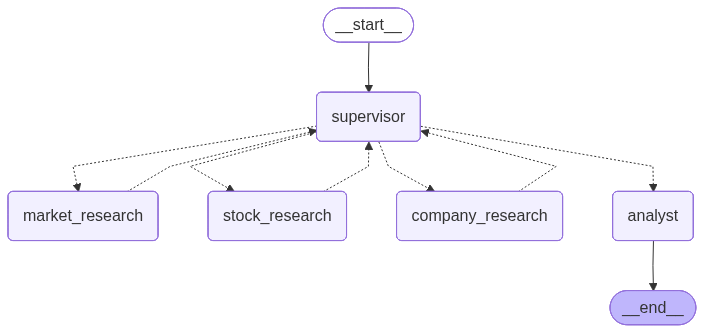

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [13]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in tesla?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in tesla?
================================ Human Message =================================
Name: market_research

I am unable to provide opinions or investment advice. However, I can provide you with the latest financial data and news about Tesla to help you make an informed decision. Would you like me to do that?
================================ Human Message =================================
Name: market_research

Would you like the latest financial data, stock prices, or recent news about Tesla? Please specify your preference.
================================ Human Message =================================
Name: market_research

### Tesla's Financial Overview

#### Latest Financial Data:
- **Company Name**: Tesla, Inc.
- **Fiscal Year**: 2025
- **Latest Quarter**: Q2 2025
  - **Net Income**: $1.19 billion
  - **Total Revenue**: $22.496 billion
  - **Gross Profit**: $3.878 billion
  - *

Failed to get ticker 'TSLA' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


================================ Human Message =================================
Name: stock_research

I attempted to retrieve the latest stock price data for Tesla (TSLA), but it seems there was an issue accessing the data. I can provide historical and financial data, or you may check real-time stock prices on a financial news website or stock trading platform for the most up-to-date information.


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TSLA?modules=secFilings&corsDomain=finance.yahoo.com&formatted=false&symbol=TSLA&crumb=Edge%3A+Too+Many+Requests


================================ Human Message =================================
Name: company_research

I attempted to retrieve the latest financial information and SEC filings for Tesla (TSLA), but it seems there wasn't any data available at the moment. For the most up-to-date financial details and filings, you may want to check Tesla's official investor relations page or the SEC's EDGAR database.
================================== Ai Message ==================================

Based on the information provided, here are some key considerations for deciding whether to buy, sell, or hold Tesla stock:

### Financial Performance
- **Net Income and Revenue**: Tesla reported a net income of $1.19 billion and total revenue of $22.496 billion for Q2 2025. This indicates profitability, but the net cash flow is negative, which might be a concern.
- **Gross Profit and Operating Expenses**: The gross profit of $3.878 billion and operating expenses of $2.955 billion suggest healthy margins, but 